In [1]:
import os
import h5py

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import iqr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from matplotlib.colors import LogNorm, SymLogNorm

import geom

plt.rc('text', usetex=True)
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('axes', titlesize=16)


In [2]:
crun = 291
modules = [3, 4, 14, 15]
basedir = "../data"

In [3]:
geom_fname = os.path.join(basedir, "agipd_taw9_oy2_1050addu_hmg5.geom")

geom_xy = geom.pixel_maps_from_geometry_file(geom_fname)

geom_x = (geom_xy[0] - 33).reshape(16, 512, 128)
geom_y = (geom_xy[1] - 36).reshape(16, 512, 128)
width = 50
geom_map = np.sqrt(geom_x * geom_x + geom_y * geom_y) < 160


In [4]:
noise = np.zeros([16, 512, 128], dtype=float)
badpx = np.ones([16, 512, 128], dtype=bool)
gain = np.zeros([16, 512, 128], dtype=float)
sig, val = [], []
for c in range(30):
    for m in modules:
        fn = os.path.join(basedir, "calib/r{:04d}/final-AGIPD{:02d}-calib.h5".format(crun, m))
        f=h5py.File(fn, "r")
        noise[m,:,:] = f["Noise"][0,0]
        badpx[m,:,:] = f["Badpixel"][0,0]
        gain[m,:,:] = f["ADU_per_Photon"][0] / f["RelativeGain"][0,0]
        f.close()

    msk = np.logical_and(geom_map, np.logical_not(badpx))
    sig.append(noise[msk])
    val.append(gain[msk])
    
sig = np.concatenate(sig)
val = np.concatenate(val)


In [5]:
with h5py.File('../data/calib/det-hist.h5','r') as f:
    h0 = f['det/hist'][:]
    g0 = f['det/g0'][()]
    b0 = f['det/b0'][()]


snr:  7.0  0.14285714285714285
11 0.7689771131681681
14 0.6498576385301067
0.6043365897539417


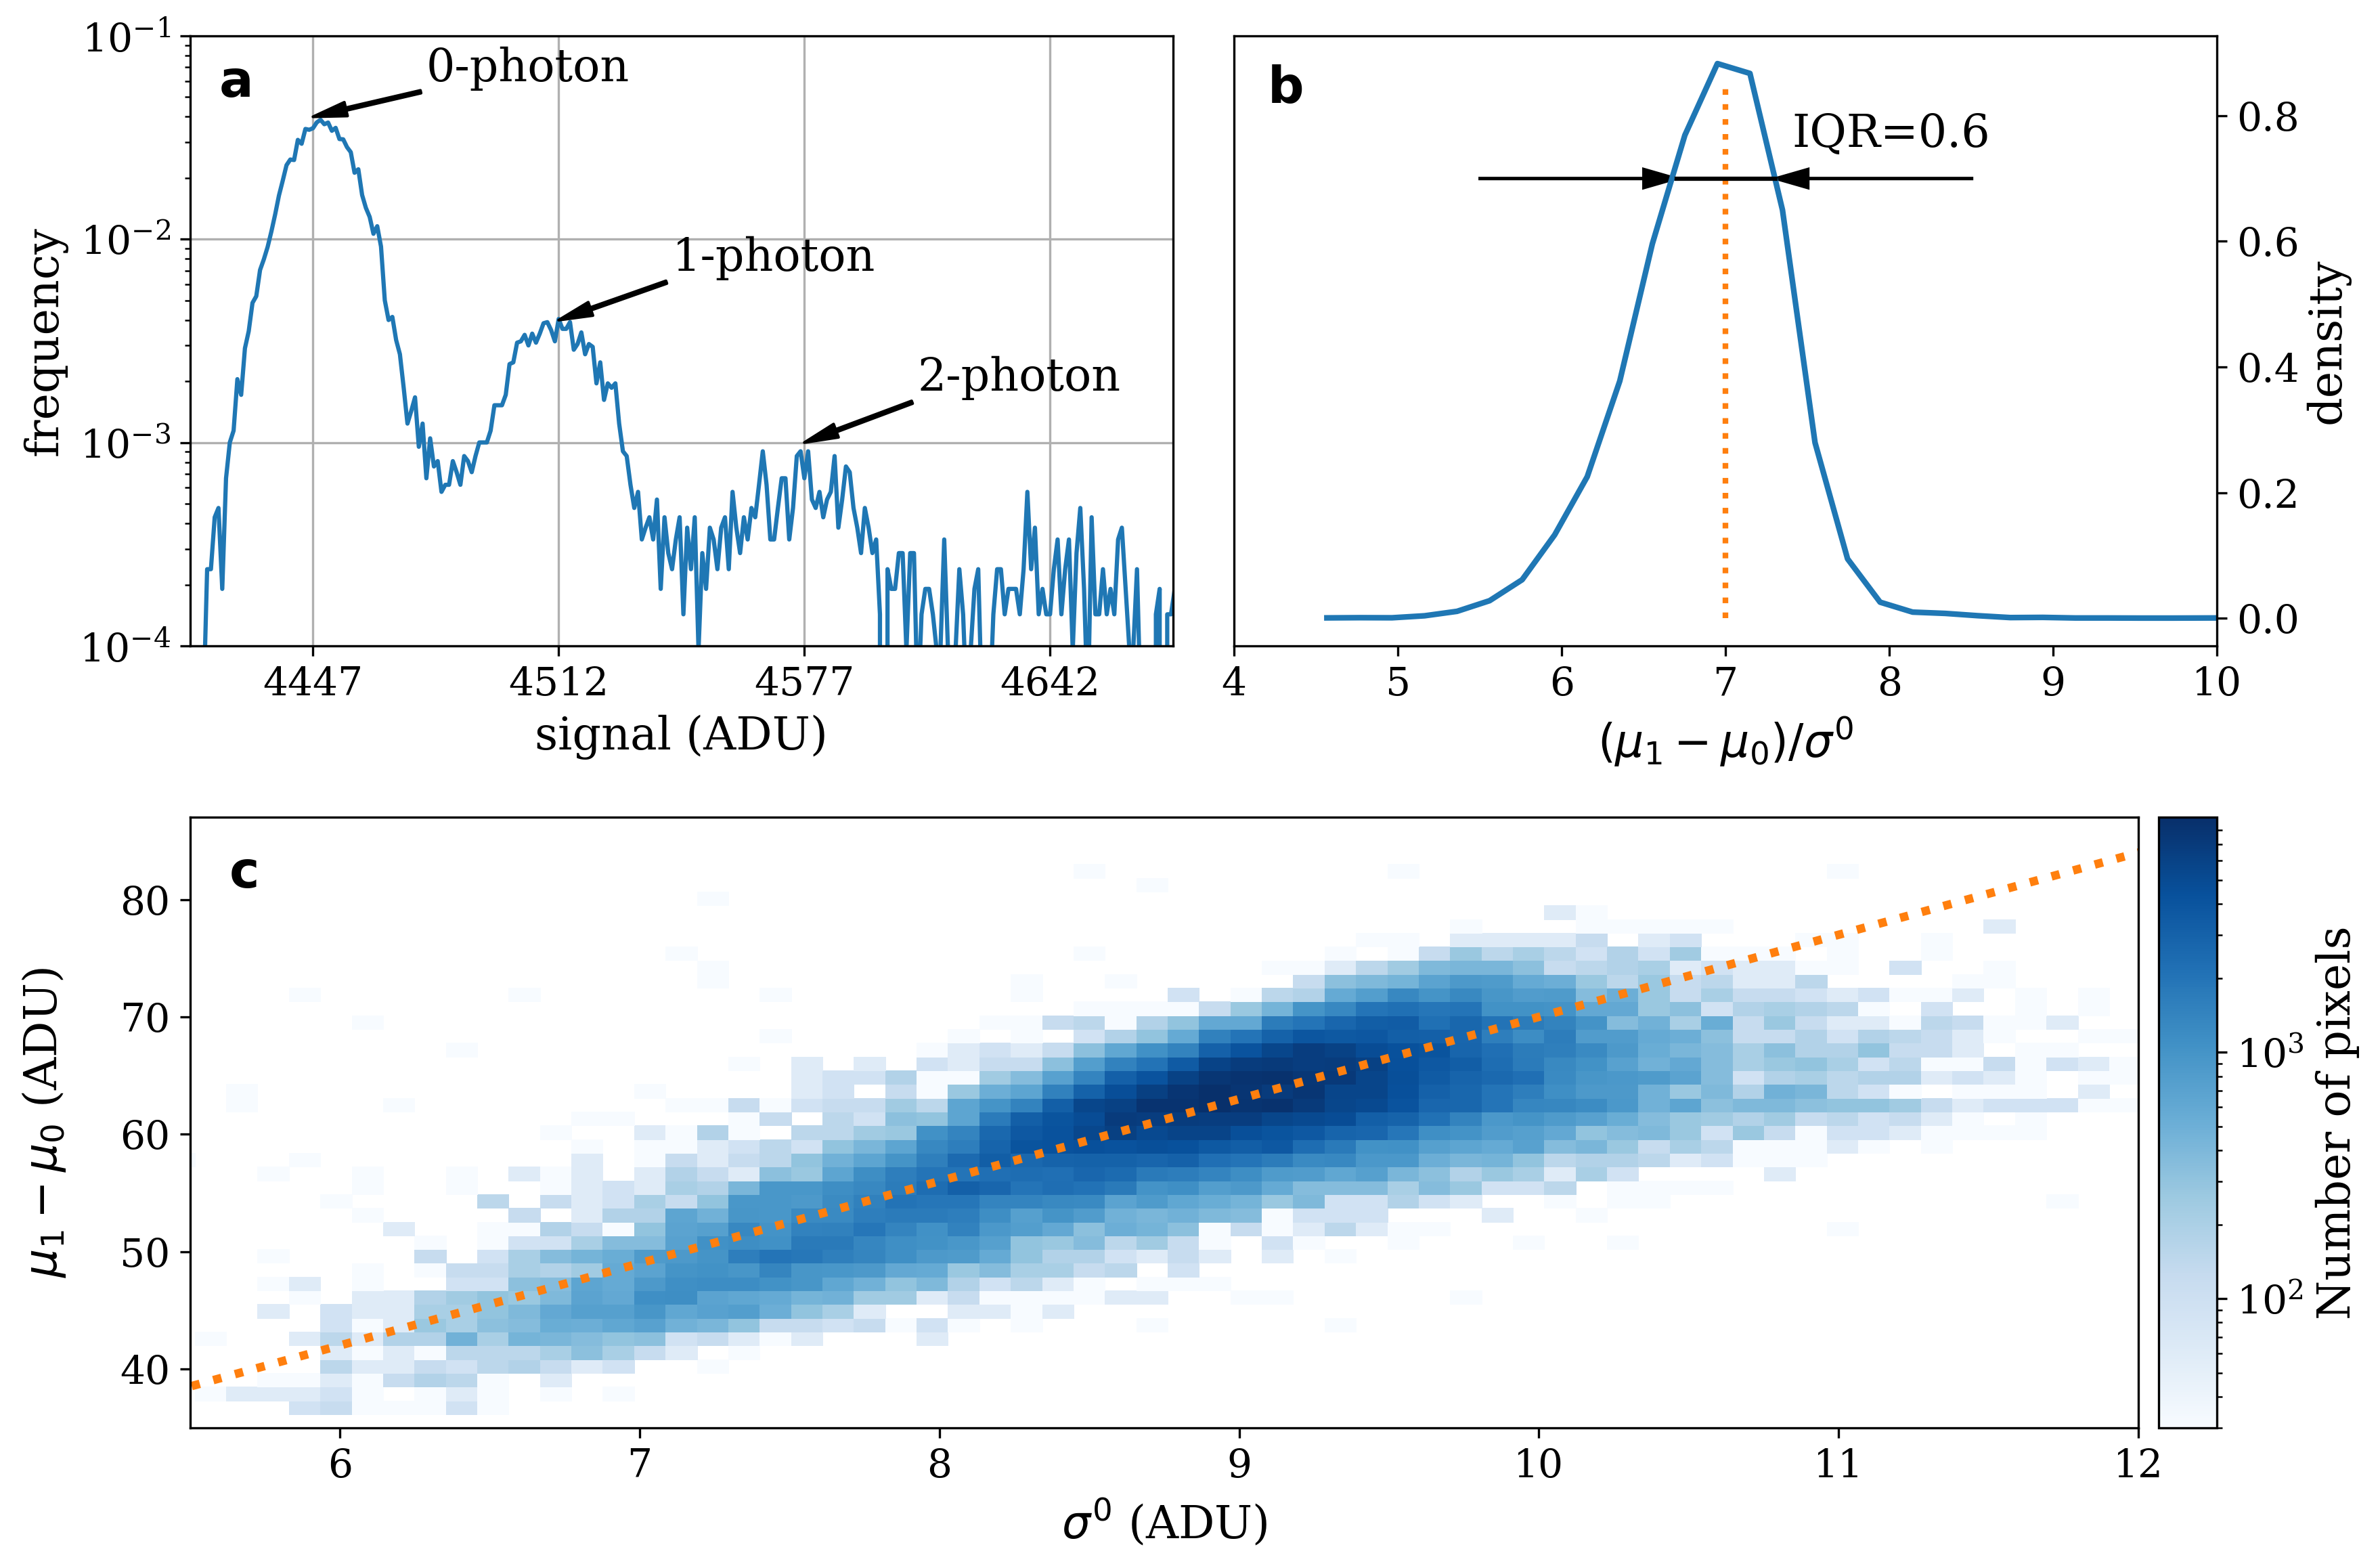

4.466956835022736
6.06993633160796 7.543616798912437 6.922924656597768
6.5997476031767475 7.204084192930689 6.922924656597768
0.6043365897539417


In [6]:
r = 7

fig = plt.figure(figsize=(12,8), tight_layout=True, dpi=300)

ax0 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

ax0.semilogy(np.arange(0,h0.size)-100+b0,h0/h0.sum())
ax0.set_xticks(np.arange(-1, 6)*g0+b0)
ax0.set_xlim(b0-g0*0.5,b0+g0*3.5)
ax0.grid(True)
#ax0.set_xticks(np.arange(0,4)*63)
ax0.set_xlabel('signal (ADU)')
ax0.set_ylabel('frequency')
ax0.annotate('0-photon', xy=(b0, 4e-2), xytext=(b0+30, 0.06), arrowprops=dict(
    facecolor='black', shrink=0, width=1, headwidth=5), ha='left')
ax0.annotate('1-photon', xy=(b0+g0, 4e-3), xytext=(b0+g0+30, 7e-3), arrowprops=dict(
    facecolor='black', shrink=0, width=1, headwidth=5), ha='left')
ax0.annotate('2-photon', xy=(b0+2*g0, 1e-3), xytext=(b0+2*g0+30, 1.8e-3), arrowprops=dict(
    facecolor='black', shrink=0, width=1, headwidth=5), ha='left')

ax0.set_ylim(1e-4, 0.1)
ax0.text(b0-25, 0.05, '$\mathbf{a}$', fontsize=18)


hhh, xed, yed, him =ax1.hist2d(sig,val, bins=(100,40), cmap=plt.cm.get_cmap('Blues'), norm=LogNorm())

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=0.1)

cbar = plt.colorbar(him, cax=cax)
cbar.ax.set_ylabel('Number of pixels')

r0, r1 = 5, 13
y0, y1 = r0*r, r1*r
ax1.plot([r0,r1], [y0, y1], 'C1:', linewidth=3)
ax1.set_xlim(5.5, 12)
ax1.set_ylim(35, 87)
ax1.set_ylabel("$\mu_1-\mu_0$ (ADU)",)
ax1.set_xlabel("$\sigma^0$ (ADU)")
ax1.text(5.63, 81, '$\mathbf{c}$', fontsize=18)
print('snr: ',(y1-y0)/(r1-r0), "", 1/r)

h, x = np.histogram(val/sig, 50, density=True)
ax2.plot(0.5*(x[1:]+x[:-1]), h, lw=2)
y = np.interp(r, 0.5*(x[1:]+x[:-1]),h)
ax2.plot([r, r], [0., .85], ':', lw=2)
ax2.set_xlabel("$(\mu_1-\mu_0) / \sigma^0$")
ax2.set_xlim(4, 10)
ax2.text(4.2, 0.82, '$\mathbf{b}$', fontsize=18)
ax2.set_ylabel('density', labelpad=2)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

iqr0, iqr1 = np.percentile(val/sig,25),np.percentile(val/sig,75)


i0 = np.argmax(x>iqr0)
print(i0,h[i0])
i1 = np.argmax(x>=iqr1)
print(i1,h[i1])

ax2.plot([iqr0+0.1,iqr1+0.1],[0.7,0.7],'k')
ax2.arrow(iqr0-0.9-0.2, 0.7, 1, 0, head_width=0.03,head_length=0.2,color='k')
ax2.arrow(iqr1+1.1+0.2, 0.7, -1, 0, head_width=0.03,head_length=0.2,color='k')
ax2.text(iqr1+0.2,0.75, 'IQR={:.1f}'.format(iqr1-iqr0))
print(iqr1-iqr0)

fig.align_ylabels([ax0,ax1]) 


plt.savefig('pdf/figure_9.pdf')
plt.savefig('eps/figure_9.eps')
plt.show()


kk = np.logical_and(val/sig < iqr0, val/sig < iqr1)
vk = np.min((val/sig)[kk])
print(vk)

print(np.percentile(val/sig,5),np.percentile(val/sig,95), np.median(val/sig))
print(np.percentile(val/sig,25),np.percentile(val/sig,75), np.median(val/sig))
print(np.percentile(val/sig,75)-np.percentile(val/sig,25))